# Problem Set 7: The Adventure of the Elusive Motif 👻 

In [3]:
!wget http://mcb112.org/w07/AluminumJesus-upstream.fa
!wget http://mcb112.org/w07/HangryHippo-upstream.fa
!wget http://mcb112.org/w07/T4-upstream.fa

--2024-10-22 11:49:14--  http://mcb112.org/w07/AluminumJesus-upstream.fa
Resolving mcb112.org (mcb112.org)... 96.126.110.11
Connecting to mcb112.org (mcb112.org)|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617 (3.5K)
Saving to: ‘AluminumJesus-upstream.fa’

AluminumJesus-upstr 100%[===================>]   3.53K  --.-KB/s    in 0s      

2024-10-22 11:49:14 (48.6 MB/s) - ‘AluminumJesus-upstream.fa’ saved [3617/3617]

--2024-10-22 11:49:14--  http://mcb112.org/w07/HangryHippo-upstream.fa
Resolving mcb112.org (mcb112.org)... 96.126.110.11
Connecting to mcb112.org (mcb112.org)|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9632 (9.4K)
Saving to: ‘HangryHippo-upstream.fa’

HangryHippo-upstrea 100%[===================>]   9.41K  --.-KB/s    in 0s      

2024-10-22 11:49:14 (58.5 MB/s) - ‘HangryHippo-upstream.fa’ saved [9632/9632]

--2024-10-22 11:49:14--  http://mcb112.org/w07/T4-upstream.fa
Resolving mcb112.o

In [331]:
import numpy as np
import matplotlib.pyplot as plt     # optional
import scipy.stats as stats         # probably don't need
import scipy.special as special     # maybe, for logsumexp()
import seaborn as sns               # optional
import pandas as pd                 # optional

%matplotlib inline

Overview of code:
- Generalized function to read fasta files recycled from pset 5
- Returns one string if there is only one sequence, returns a list of strings if there are many reads stored in one file

In [335]:
#Generalized FASTA parsing function able to read one sequence or multiple sequences
def read_fasta(name):
    seqs = [] #DNA sequences to return
    with open(name, 'r') as file:
        seq = '' #String representing each sequence
        file.readline() #Skip the first line
        for line in file:
            if line[0] == '>': #> represents a new sequence
                seqs.append(seq.upper()) #Add completed sequence to the list of sequences
                seq = '' #Reset sequence to nothing to read new sequence
            else: 
                seq += line.strip() #Get rid of the new line character at the end and concatenate this line to the current sequence
        seqs.append(seq.upper()) #Capitalize sequence for consistency
    if len(seqs) == 1: #If the whole file is one sequence
        return seq
    else: 
        return seqs

In [337]:
aluminum_jesus = read_fasta('AluminumJesus-upstream.fa')
hangry_hippo = read_fasta('HangryHippo-upstream.fa')
t4 = read_fasta('T4-upstream.fa')

# 1. conjunction junction what's your function 🚫 expectation-maximization what in tarnation ✅ 

Overview of code:
- Create a function that implements an expectation-maximization algorithm for finding a sequence motif, taking the motif sequence width as an input
- This function will consist of initialization, iteration, and termination
    - The iteration will consist of an expectation step and a maximization step
- Expectation step: infer motif positions and expected counts given the current motif model
    - Calculate a posterior distribution for the inferred motif position on an input sequence
        - From Bayes' Theorem in the notes and our use of a uniform prior, we have for each $1\leq s \leq N$ $$P(\lambda^s|\Theta,X^s) = \frac{P(X^s|\Theta, \lambda^s)P(\lambda^s)}{\sum_{\lambda^s=1}^{L-W+1}P(X^s|\Theta, \lambda^s)P(\lambda^s)} = \frac{P(X^s|\Theta, \lambda^s)}{\sum_{\lambda^s=1}^{L-W+1}P(X^s|\Theta, \lambda^s)}$$
        - The likelihood term is $$P(X^s|\Theta, \lambda^s) = \prod_i^{\lambda^s-1}f(X_i^s)\prod_{k=1}^Wp_k(X^s_{\lambda^s+k-1})\prod_{\lambda^s+W}^{L}f(X_i^s)$$ and so $$log (P(X^s|\theta, \lambda^s)) = \sum_i^{\lambda^s-1}log (f(X_i^s)) + \sum_{k=1}^W log (p_k(X^s_{\lambda^s+k-1})) + \sum_{\lambda^s+W}^{L}log (f(X_i^s))$$
    - Collect expected counts at each position of a new position-specific motif matrix, given those posterior distributions for each input sequence
        - Expected counts are calculated as the nucleotide counts for a given $\lambda^s$ weighted by posterior probability of motif position such that the motif counts $c_k(a)$ and the background counts $c(a)$ are given by $$c_k(a) = \sum_{s=1}^N \sum_{\lambda^s = 1}^{L-W+1} P(\lambda^s|X^s, \Theta)\delta (X^s_{\lambda^s+k-1} = a)$$ $$c(a) = \sum_{s=1}^N \sum_{\lambda^s = 1}^{L-W+1} (\sum_{i=1}^{\lambda^s-1} P(\lambda^s|X^s, \Theta)\delta (X^s_{i} = a) + \sum_{i=\lambda^s+W}^{L} P(\lambda^s|X^s, \Theta)\delta (X^s_{i} = a))$$
- Maximization step: infer a new motif model given the expected counts
    - Take a position-specific motif matrix containing these expected counts, and estimate probabilities from those counts
    - This applies to the background distribution and all the $W$ position-specific distributions of $p_k$
    - Maximizes with a pseudocount to avoid potential division by 0 such that $$\hat{p_{i}} = \frac{c_j+1}{\sum_j c_j+1}$$

In [339]:
def EM_motif_finder(seqs, W, plot = True):
    seqs = [['ACGT'.find(base) for base in seq] for seq in seqs] #Digitizing sequences

    #Function to calculate counts of a sequence given motif position
    def calculate_counts(seq, lambda_s):
        motif_counts = np.zeros((4, W)) #Initializing array of motif counts, separating by position
        background_counts = np.zeros(4) #Initializing array of background counts
        for j in range(W):
            motif_base = seq[lambda_s + j]
            motif_counts[motif_base][j] += 1 #Adding occurrences of bases at a given position within motif to motif counts
        for base in seq[:lambda_s] + seq[lambda_s + W:]:
            background_counts[base] += 1 #Adding occurrences of base in the background to background counts
        return motif_counts, background_counts
    
    #Function to calculate expected counts given PWM and background frequencies
    def expected_counts(pwm, bg):
        expected_motif_counts = np.zeros((4, W))
        expected_bg_counts = np.zeros(4)
        for seq in seqs: #Iterating through each sequence
            log_motif_probs = np.zeros(len(seq) - W + 1) #Initializing array to contain probability of motif occurring at specific position
            for motif_position in range(len(seq) - W + 1): #Iterating through all possible motif positions
                #Calculating log likelihoods of sequence assuming motif position
                log_likelihood = sum(np.log(bg[seq[i]]) for i in range(motif_position)) #Log likelihoods of background upstream of motif
                log_likelihood += sum(np.log(pwm[seq[motif_position + j]][j]) for j in range(W)) #Log likelihood of motif
                log_likelihood += sum(np.log(bg[seq[i]]) for i in range(motif_position + W, len(seq))) #Log likelihoods of background downstream of motif
                log_motif_probs[motif_position] = log_likelihood
            log_motif_probs -= special.logsumexp(log_motif_probs) #Normalizing motif probabilities
            motif_probs = np.exp(log_motif_probs) #Exponentiating log probabilities to get out of log space
            for motif_position, prob in enumerate(motif_probs):
                motif_count, background_count = calculate_counts(seq, motif_position) #Calculating counts for a specific sequence at a specific motif position
                expected_motif_counts += motif_count * prob #Adding motif counts weighted by probability of motif occurring at that position
                expected_bg_counts += background_count * prob #Adding background counts weighted by probability of motif occurring at that position
        return expected_motif_counts, expected_bg_counts

    #Initialization - choosing a random λ with uniform probability 1/(L-W+1) for each sequence
    rng = np.random.default_rng()
    lambdas = [rng.integers(0, len(seq) - W) for seq in seqs] #Choosing a uniformly random motif start position lambda for each sequence

    #Initial counts
    init_motif_counts = np.zeros((4, W))
    init_background_counts = np.zeros(4)
    for i, seq in enumerate(seqs):
        m_counts, b_counts = calculate_counts(seq, lambdas[i])
        init_motif_counts += m_counts
        init_background_counts += b_counts

    #Initial PWM and background distribution
    pwm = (init_motif_counts + 1) / np.sum(init_motif_counts + 1, axis = 0) #Adding pseudocount before calculating maximum likelihood pwm - normalizing over the counts for each position
    bg = init_background_counts + 1/ np.sum(init_background_counts + 1) #Adding pseudocount before calculating maximimum likelihood background probabilities - note that pseudocount probably isn't necessary since background most likely has all four bases

    log_likelihood_ratios = [] #List to store log likelihoods ratios of data over time
    #Iterative expectation-maximization steps - number of loops decided by plot of log likelihood 
    for i in range(100):
        expected_motif_counts, expected_bg_counts = expected_counts(pwm, bg) #Expectation       
        pwm = (expected_motif_counts + 1) / np.sum(expected_motif_counts + 1, axis=0) #Maximization with pseudocount
        bg = (expected_bg_counts + 1) / np.sum(expected_bg_counts + 1)

        #Calculating log-likelihood ratio 
        llr = 0
        for k in range(W):
            for a in range(4):
                if pwm[a][k] != 0:
                    llr += pwm[a][k] * np.log2(pwm[a][k] / bg[a]) 
        log_likelihood_ratios.append(llr)
        

    #Plotting log-likelihood ratios
    if plot:
        fig, ax = plt.subplots(figsize = (6, 8))
        ax.plot(log_likelihood_ratios, color = 'darkorange')
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Log-Likelihood Ratio")
        ax.set_title("Log-Likelihood Ratio Across EM Algorithm Iterations")
        plt.show()

    #Calculating relative entropy
    relative_entropy = 0
    for k in range(W):
        for a in range(4):
            if pwm[a][k] != 0:
                relative_entropy += pwm[a][k] * np.log2(pwm[a][k] / bg[a]) 
    return relative_entropy, pwm

# 2. fake it 'til you make it 👍 

Overview of code:
- Given a known motif PWM of length W and a known background composition, generate a synthetic positive control dataset of size the average of the provided datasets and with sequence length the average length of the database sequence lengths
    - Using the PWm and background composition, generate a background sequence and a motif sequence
    - Insert the motif sequence into the background sequence at a uniformly distributed position

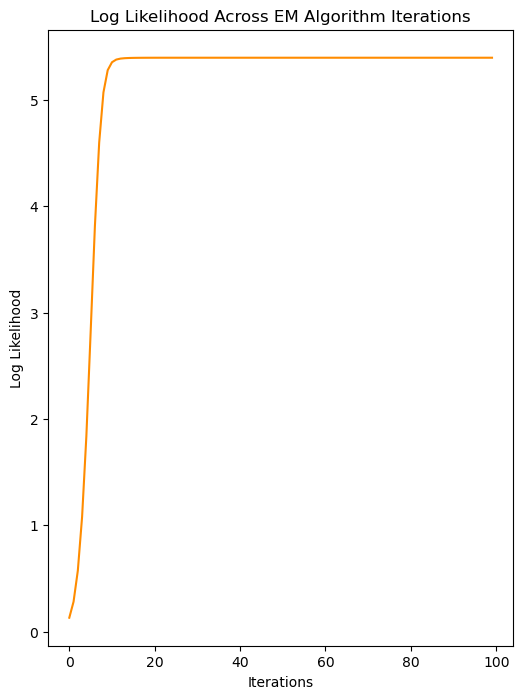

[[0.69994761 0.05272939 0.07368929 0.59604313 0.0590787  0.03747637]
 [0.07560896 0.07415631 0.15277552 0.12848248 0.80032513 0.69919172]
 [0.13245368 0.16844932 0.06613182 0.20225989 0.05352638 0.19359533]
 [0.09198975 0.70466498 0.70740337 0.07321451 0.08706979 0.06973658]]


In [255]:
N = round((len(aluminum_jesus) + len(hangry_hippo) + len(t4)) / 3) #Number of sequences to generate is average of size of three databases
L = round(sum([len(i) for i in (aluminum_jesus + hangry_hippo + t4)]) / (len(aluminum_jesus) + len(hangry_hippo) + len(t4))) #Length of sequences to generate is average length of database sequences
W = 6

bg = np.array([0.15, 0.35, 0.35, 0.15]) #Known background composition for test
pwm = np.array([[0.70, 0.05, 0.05, 0.65, 0.05, 0.05], 
               [0.10, 0.05, 0.10, 0.15, 0.80, 0.75],
               [0.10, 0.10, 0.10, 0.15, 0.05, 0.15],
               [0.10, 0.80, 0.75, 0.05, 0.10, 0.05]]) #Known pwm (note that this pset is ATTACCing me :( )

rng = np.random.default_rng()
positive_control = []
for i in range(N):
    random_motif = []
    for j in range(W):
        random_motif.append(rng.choice(['A','C','G','T'], p = pwm[:, j])) #Sampling nucleotide with probability distribution given by jth column of pwm
    random_bg = rng.choice(['A','C','G','T'], size = L - W, p = bg) #Generating a sample of size L - W with probabilities from background distribution
    positive_control.append(''.join(np.insert(random_bg, rng.choice(L - W + 1), random_motif))) #Inserting motif at random position with uniform probability
        
positive_control_score, positive_em_motif = EM_motif_finder(positive_control, W)
print(positive_em_motif)

Yes, the EM algorithm was able to identify the embedded motif fairly well. While the probabilities do not exactly align with the known PWM, they are all very close, and it is possible that deviations are a result of the positive controls being a generated sample of limited size.

In [256]:
print(positive_control_score)

5.396778853071035


# 3. is this the real life? is this just fantasy? 🤔 

Overview of code:
- Generate a synthetic negative control database of same size and length as above but with no embedded motif, just sampling from the background distribution
- Compare the score of the EM motif-identifying model for the negative and positive controls

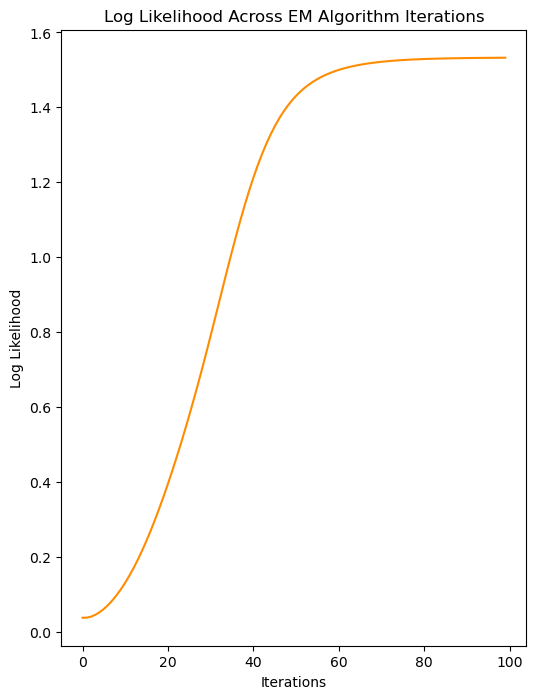

In [259]:
negative_control = []
for i in range(N):
    negative_control.append(''.join(rng.choice(['A','C','G','T'], size = L, p = bg))) #Generate bases i.i.d from background distribution, joined together into string

negative_control_score, negative_em_motif = EM_motif_finder(negative_control, W)

In [260]:
print("Positive control score: " + str(round(positive_control_score, 2)))
print("Negative control score: " + str(round(negative_control_score, 2)))

Positive control score: 5.4
Negative control score: 1.53


The positive control score is consistently greater than the negative control score. Additionally, under the positive control, the EM model was able to converge to the maximum log-likelihood score over fewer iterations than under the negative control.

# 4. i'm looking for a site in genome. 6 wide. no lies. 🤑 

Overview of code:
- Apply the EM motif finder to the three datasets
- Test across a range of W to identify the most likely ribosome binding site consensus motif

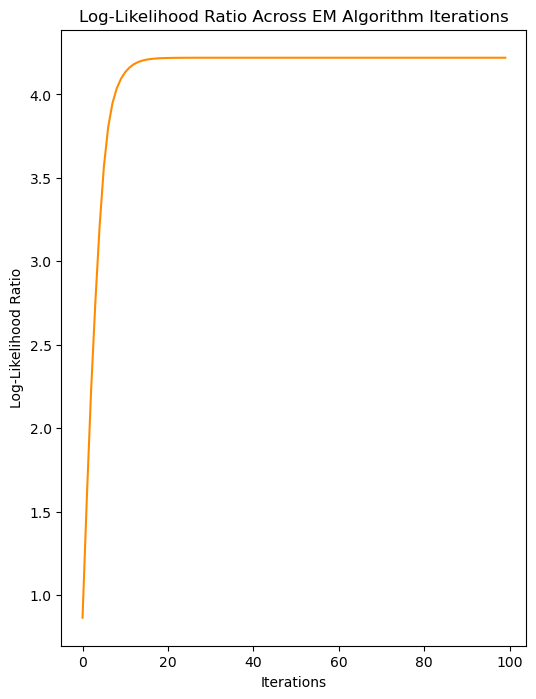

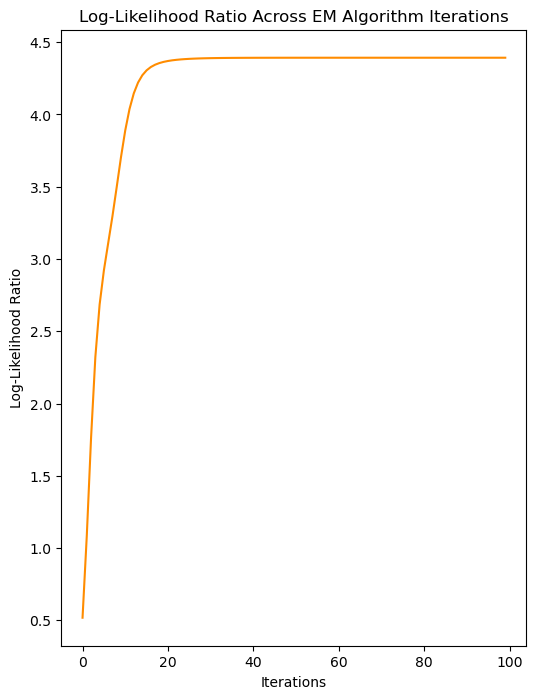

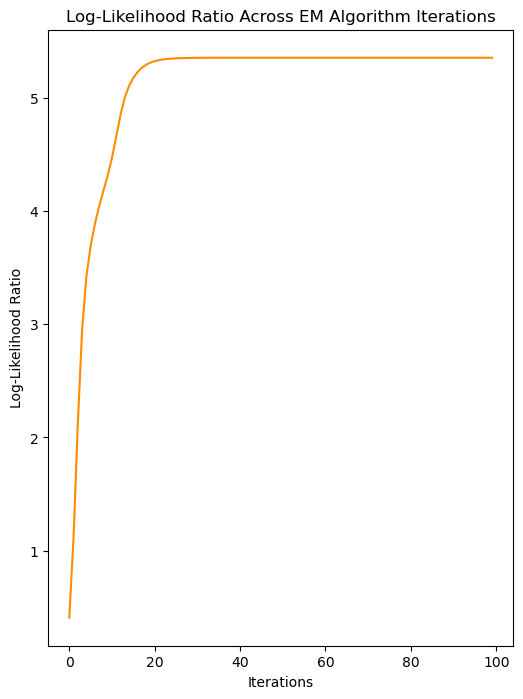

Aluminum Jesus score: 4.22
[[0.04405241 0.29234408 0.72455194 0.03534059 0.14071988 0.38457036]
 [0.14312262 0.04691475 0.03246658 0.11128772 0.15732038 0.14426344]
 [0.78919467 0.64380959 0.080392   0.83267561 0.61255064 0.20972441]
 [0.0236303  0.01693157 0.16258948 0.02069608 0.08940909 0.26144179]]
Hangry Hippo score: 4.39
[[0.08103283 0.11648559 0.76206953 0.1410125  0.30602554 0.37834272]
 [0.02677129 0.03850721 0.04286142 0.03015349 0.05404392 0.15434253]
 [0.79246968 0.82272555 0.06812567 0.68557783 0.46913896 0.26646208]
 [0.0997262  0.02228166 0.12694337 0.14325618 0.17079158 0.20085268]]
T4 score: 5.35
[[0.32689408 0.30123258 0.77573913 0.04577001 0.17494144 0.62669776]
 [0.10956078 0.06616696 0.02485607 0.00611537 0.01925898 0.08660998]
 [0.17254489 0.54633348 0.07105804 0.91995853 0.74096452 0.02305743]
 [0.39100025 0.08626697 0.12834676 0.0281561  0.06483506 0.26363484]]


In [341]:
W = 6

aj_score, aj_motif = EM_motif_finder(aluminum_jesus, W)
hh_score, hh_motif = EM_motif_finder(hangry_hippo, W)
t4_score, t4_motif = EM_motif_finder(t4, W)

print("Aluminum Jesus score: " + str(round(aj_score, 2)))
print(aj_motif)
print("Hangry Hippo score: " + str(round(hh_score, 2)))
print(hh_motif)
print("T4 score: " + str(round(t4_score, 2)))
print(t4_motif)

If we assume a probability cutoff of 0.5 for whether or not to include a base in our motif, for W = 6, the consensus sequence for the ribosome binding site appears to be the following:
- Aluminum Jesus: G G A G G
- Hangry Hippo: G G A G
- T4: G A G G A 

Note that these are just the most probable bases at each position and that some positions do not seem as strongly conserved as others. Therefore, we should test our model over a range of W values to better ascertain the length of the consensus sequence.

In [342]:
#Testing over a range of W

#Lists to store the PWMs for each value of W
aj_pwms = []
hh_pwms = []
t4_pwms = []

#Aluminum Jesus
for W in range(4, 9):
    aj_score, aj_motif = EM_motif_finder(aluminum_jesus, W, plot = False)
    print(aj_score)
    print(aj_motif)
    aj_pwms.append(aj_motif)

#Hangry Hippo
for W in range(4, 9):
    hh_score, hh_motif = EM_motif_finder(hangry_hippo, W, plot = False)
    print(hh_score)
    print(hh_motif)
    hh_pwms.append(hh_motif)

#T4
for W in range(4, 9):
    t4_score, t4_motif = EM_motif_finder(t4, W, plot = False)
    print(t4_score)
    print(t4_motif)
    t4_pwms.append(t4_motif)

3.5838498116436615
[[0.03873674 0.26461941 0.66419857 0.0327221 ]
 [0.0675626  0.05075126 0.0512238  0.11640662]
 [0.8748448  0.66886523 0.09414138 0.83150179]
 [0.01885586 0.0157641  0.19043625 0.01936949]]
3.9578180860440315
[[0.04211834 0.2574424  0.71762306 0.04481232 0.182273  ]
 [0.10264016 0.05927828 0.04569931 0.10736575 0.16846049]
 [0.83845691 0.66769692 0.06097316 0.82518496 0.54874165]
 [0.01678459 0.01558239 0.17570446 0.02263697 0.10052486]]
4.220004183186906
[[0.04405241 0.29234408 0.72455194 0.03534059 0.14071988 0.38457036]
 [0.14312262 0.04691475 0.03246658 0.11128772 0.15732038 0.14426344]
 [0.78919467 0.6438096  0.080392   0.83267561 0.61255064 0.20972442]
 [0.0236303  0.01693157 0.16258948 0.02069608 0.08940909 0.26144179]]
4.59729569816958
[[0.06342101 0.35869376 0.65676418 0.04805784 0.10778536 0.47591693
  0.07391075]
 [0.17569489 0.0562794  0.06069067 0.09290271 0.11771073 0.08705658
  0.24046123]
 [0.70977485 0.52073173 0.15100551 0.84190245 0.70990639 0.13671

Overview of code:
- For each value of W, plot a line graph of the maximum probabilities for each residue and label each maximum probability according to its nucleotide

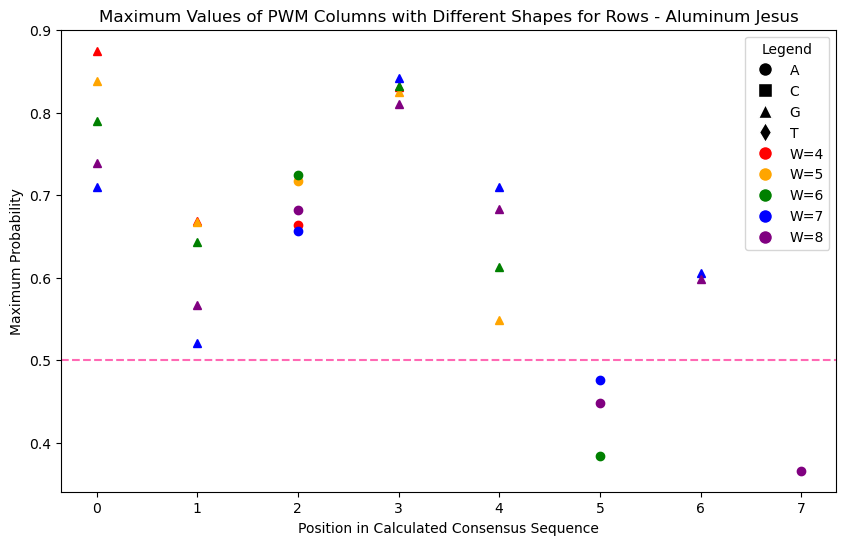

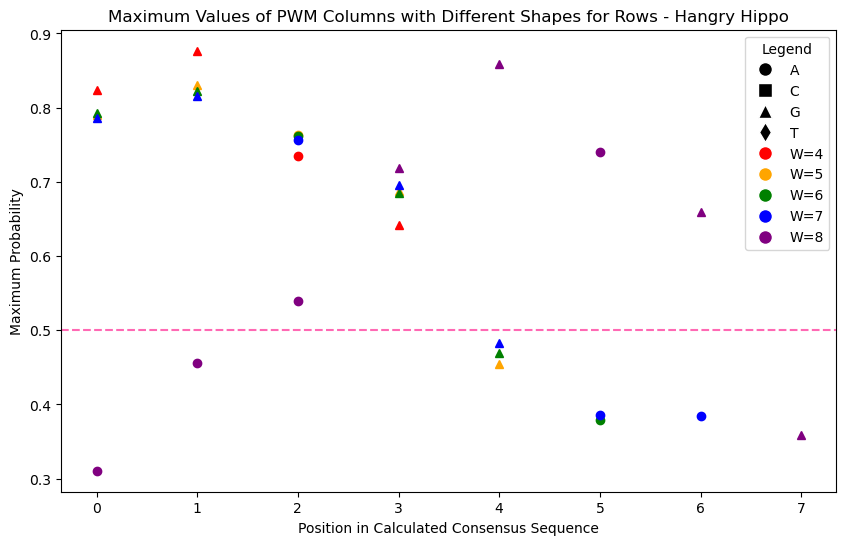

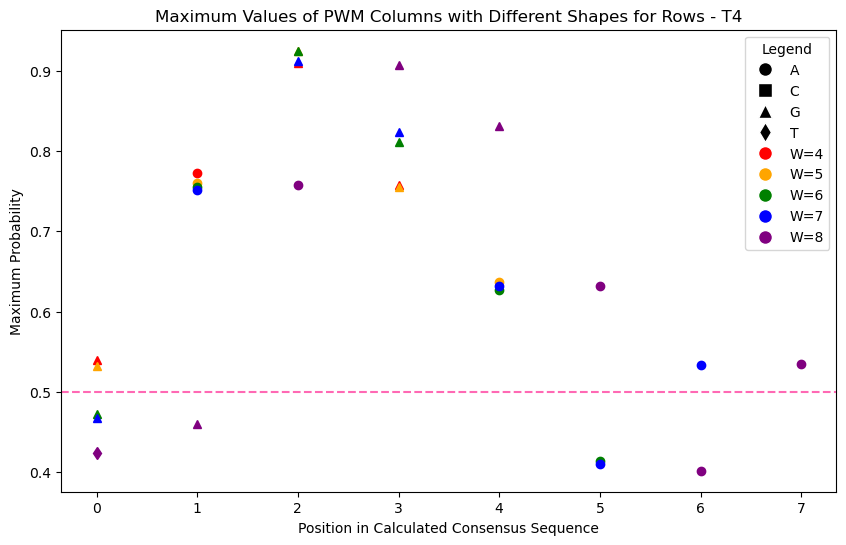

In [357]:
def max_probs_plot(pwms, name):
    #Create a line plot with different shapes for maximum values of each column
    fig, ax = plt.subplots(figsize = (10, 6))
    shapes = ['o', 's', '^', 'd']  #Shapes for A, C, G, T
    bases = ['A', 'C', 'G', 'T']
    colors = ['red', 'orange', 'green', 'blue', 'purple']  #Colors for different W values

    W_vals = [4, 5, 6, 7, 8] #Values of W to test
    for i, W in enumerate(W_vals):
        pwm = pwms[i]
        max_values = np.max(pwm, axis=0)  #Maximum values in each column
        max_indices = np.argmax(pwm, axis=0)  #Indices of maximum values (corresponding to rows)
        
        for j in range(W):
            ax.plot(j, max_values[j], marker = shapes[max_indices[j]], color = colors[i])
    
    # Add legend and labels
    legend_elements = [plt.Line2D([0], [0], marker = shape, color = 'w', label = f'{label}', markerfacecolor = 'k', markersize = 10) for shape, label in zip(shapes, bases)]
    legend_elements += [plt.Line2D([0], [0], marker = 'o', color = 'w', label = f'W={W}', markerfacecolor = color, markersize = 10) for W, color in zip(W_vals, colors)]
    ax.legend(handles = legend_elements, title = 'Legend', loc = 'upper right')
    ax.set_xlabel('Position in Calculated Consensus Sequence')
    ax.set_ylabel('Maximum Probability')
    ax.set_title('Maximum Values of PWM Columns with Different Shapes for Rows - ' + name)
    ax.axhline(y = 0.5, linestyle = 'dashed', color = 'hotpink')
    plt.show()

max_probs_plot(aj_pwms, 'Aluminum Jesus')
max_probs_plot(hh_pwms, 'Hangry Hippo')
max_probs_plot(t4_pwms, 'T4')

If we use 0.5 as a naive threshold for the minimum probability a residue must have to consider it part of our consensus sequence and assume that a consensus sequence must be contiguous, we are looking for the longest run in our PWM such that for all positions there is a probability above 0.5. \
Under these requirements, we have that Aluminum Jesus has a consensus ribosome binding site sequence of GGAGG, Hangry Hippo has a consensus sequence of AGGAG, and T4 has a consensus sequence of AGGA.

# the motif ghosted me 😔 👻 

In [359]:
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.0.11

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



python(48270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
